In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

torch.manual_seed(42)
transform=T.Compose([
    T.ToTensor(),
    T.Normalize([0.5],[0.5])])

In [3]:
train_set=torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform) 

100.0%


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100.0%


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100.0%


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100.0%

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
batch_size=32
train_loader=torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True)

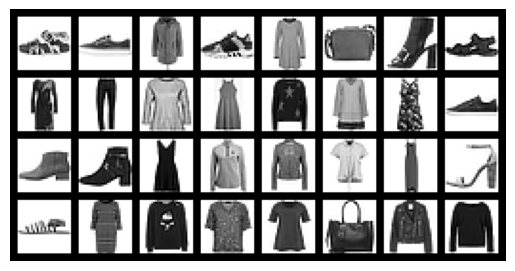

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

images, labels = next(iter(train_loader))
# Plot all the images of the 1st batch in grid
grid = make_grid(0.5-images/2, 8, 4)
plt.imshow(grid.numpy().transpose((1, 2, 0)),
          cmap="gray_r")
plt.axis("off")
plt.show()

In [6]:
import torch
import torch.nn as nn

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
# the discriminator D is a binary classifier
D=nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()).to(device)

In [7]:
G=nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 784),
    nn.Tanh()).to(device)

In [8]:
loss_fn=nn.BCELoss()
lr=0.0001
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

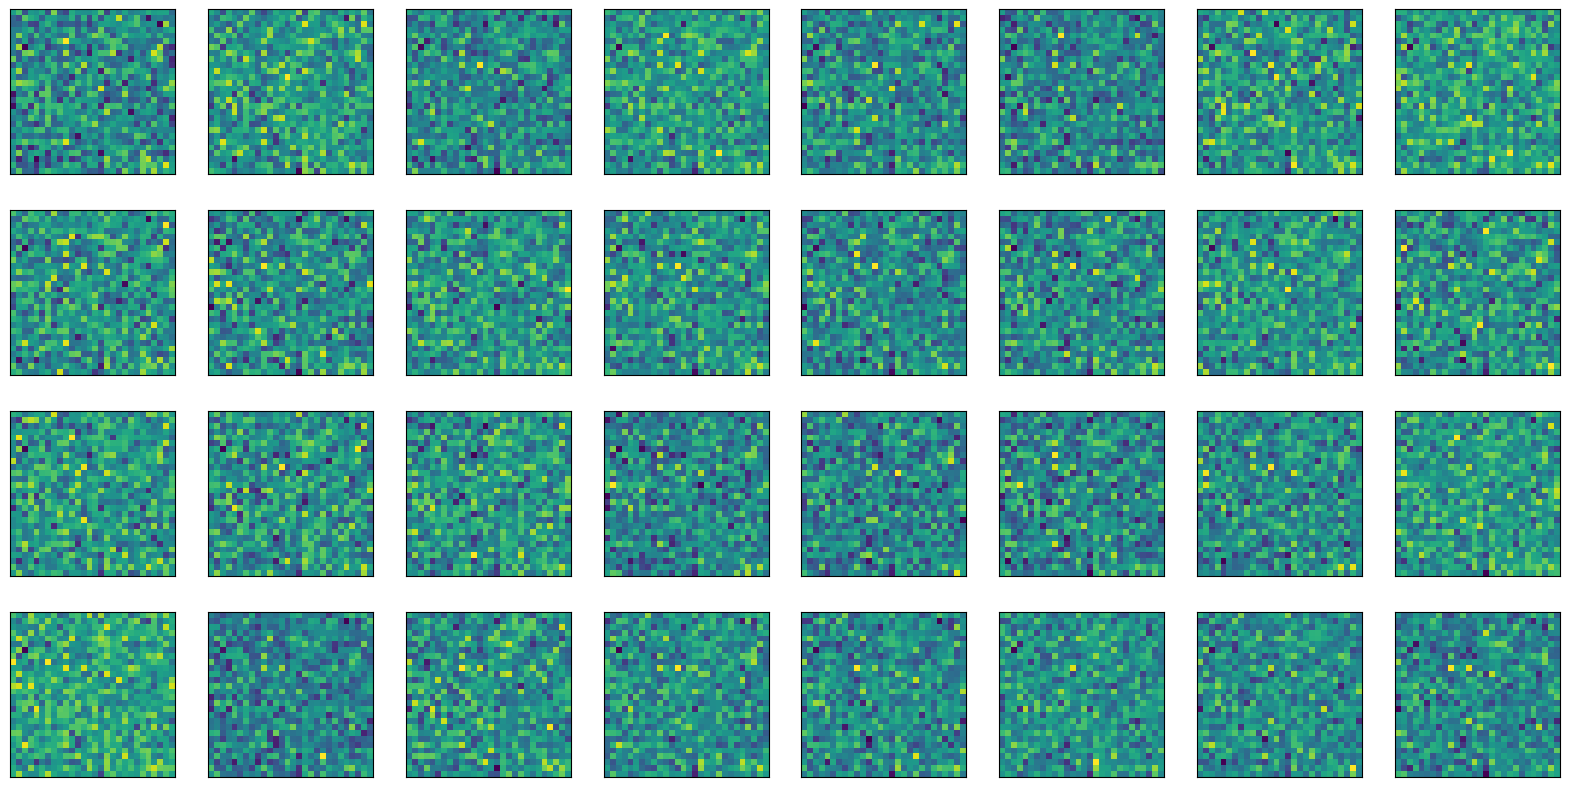

In [9]:
import matplotlib.pyplot as plt

def see_output():
    noise=torch.randn(32,100).to(device=device)
    fake_samples=G(noise).cpu().detach()    #A
    plt.figure(dpi=100,figsize=(20,10))
    for i in range(32):
        ax=plt.subplot(4, 8, i + 1)    #B
        img=(fake_samples[i]/2+0.5).reshape(28, 28)
        plt.imshow(img)    #C
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
see_output()    #D     

In [10]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)
def train_D_on_real(real_samples):
    #r=torch.FloatTensor(real_samples)
    r=real_samples.reshape(-1,28*28).to(device)
    out_D=D(r)    
    labels=torch.ones((r.shape[0],1)).to(device)
    loss_D=loss_fn(out_D,labels)    
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()    
    return loss_D

In [11]:
def train_D_on_fake():        
    noise=torch.randn(batch_size,100).to(device=device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

In [12]:
def train_G(): 
    noise=torch.randn(batch_size,100).to(device=device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G

at epoch 10, dloss: 0.7692742347717285, gloss 1.8848769664764404


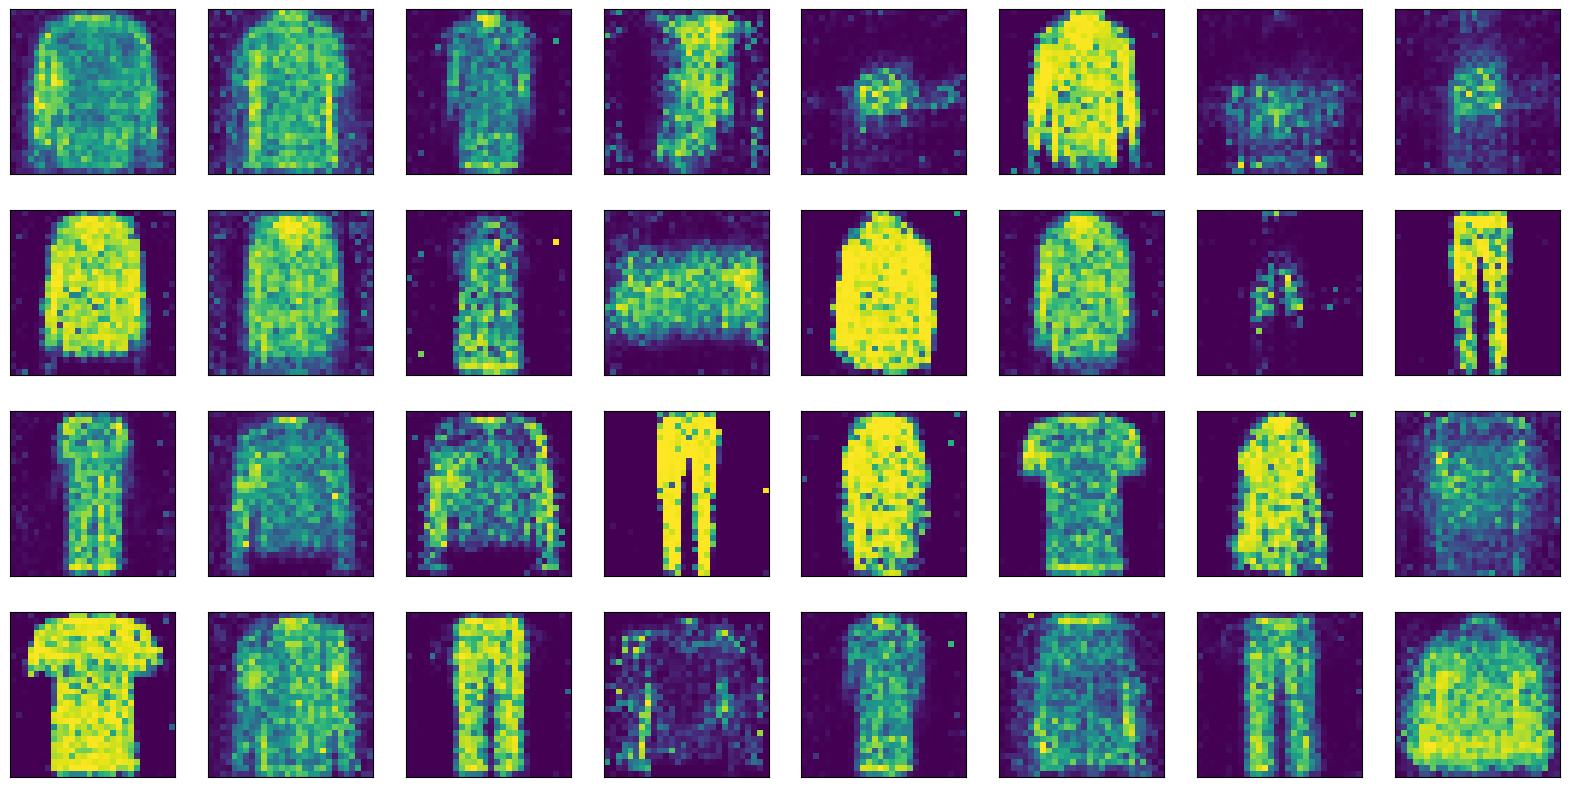

at epoch 20, dloss: 1.0678483247756958, gloss 1.1934919357299805


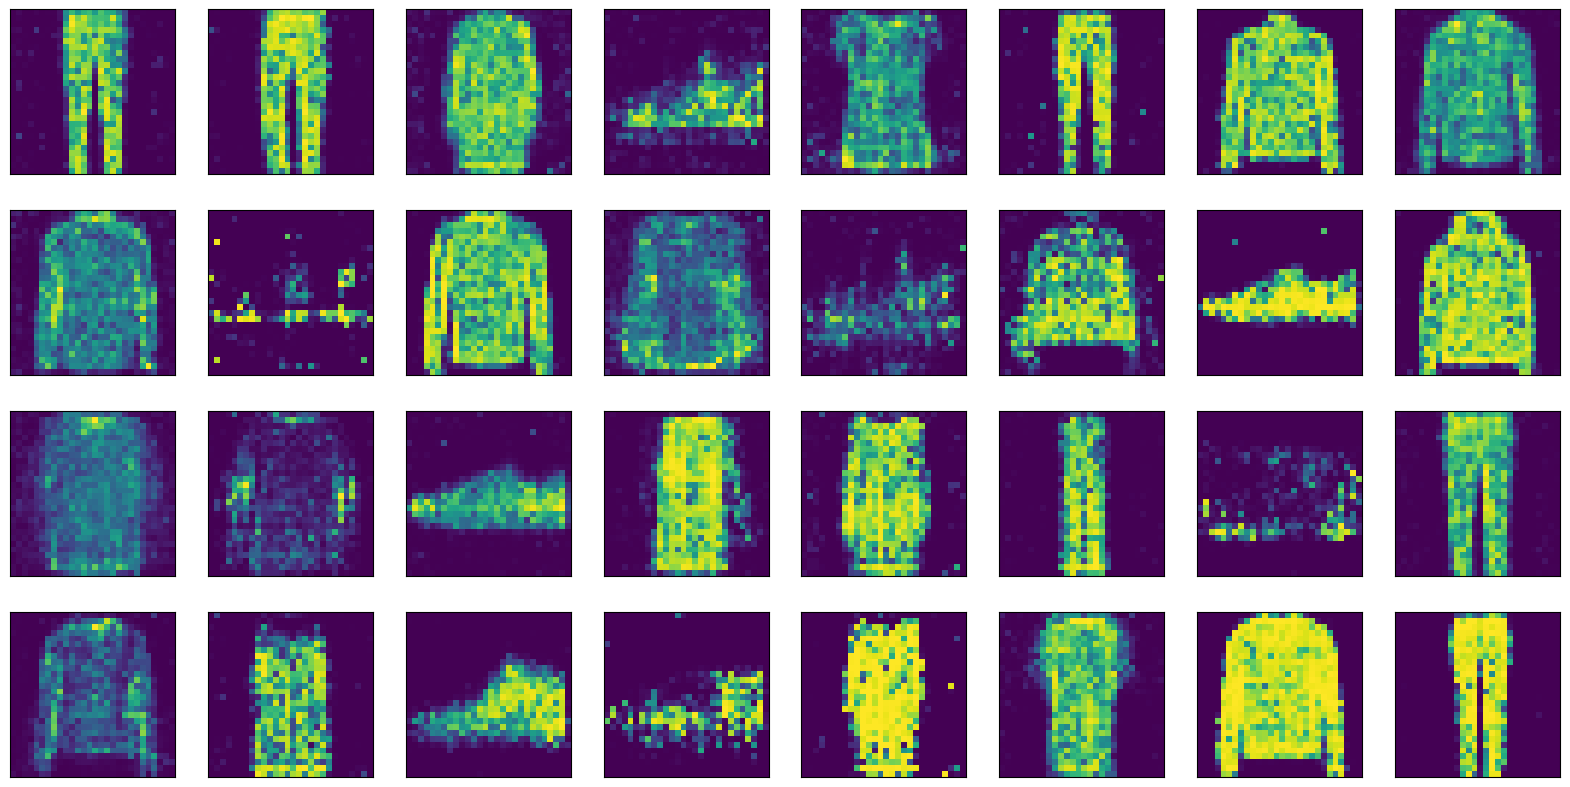

at epoch 30, dloss: 1.1693562269210815, gloss 1.009452223777771


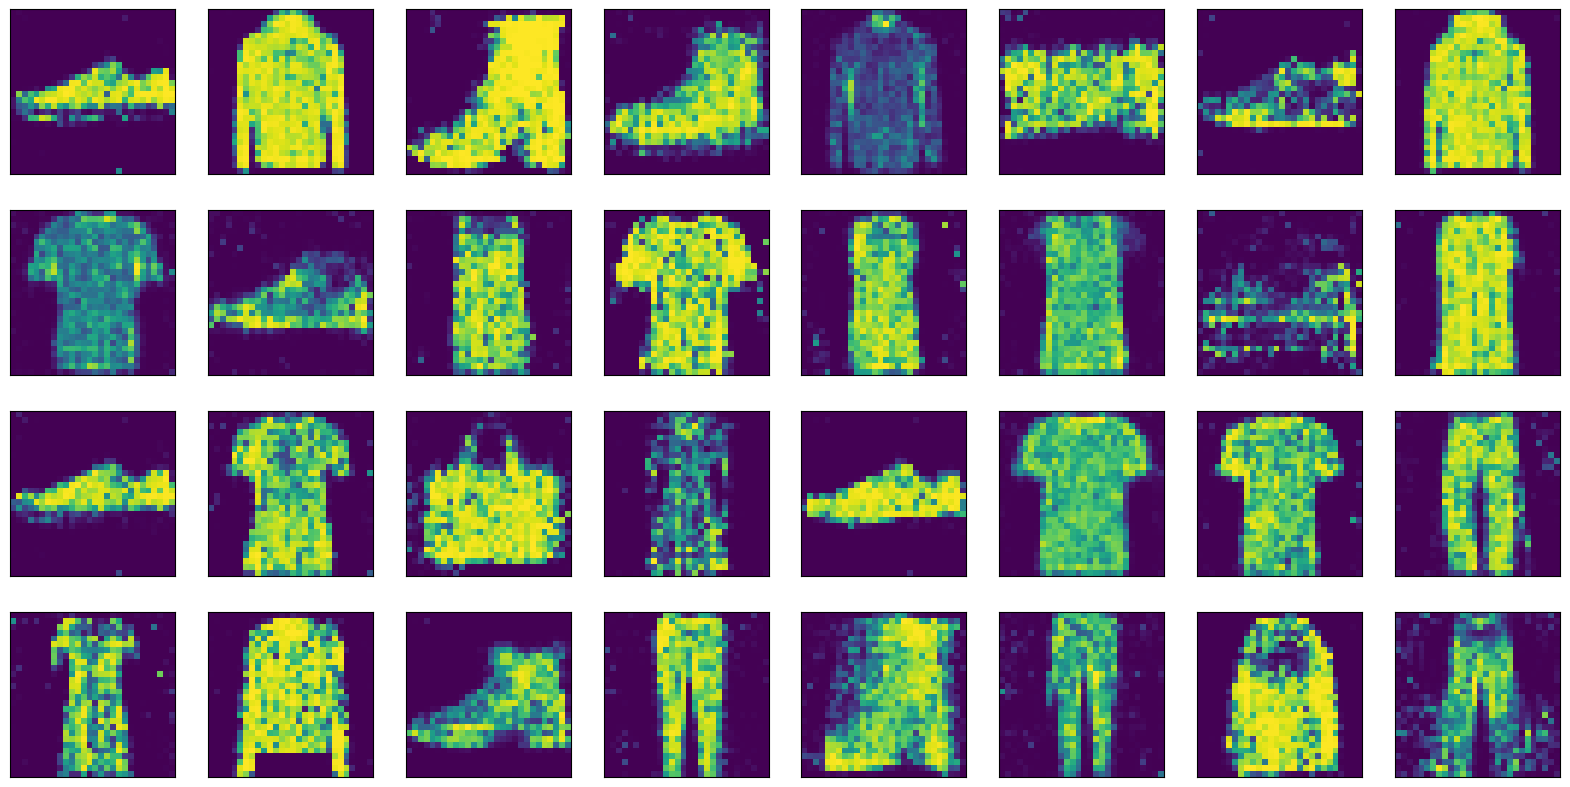

at epoch 40, dloss: 1.2177757024765015, gloss 0.9327487945556641


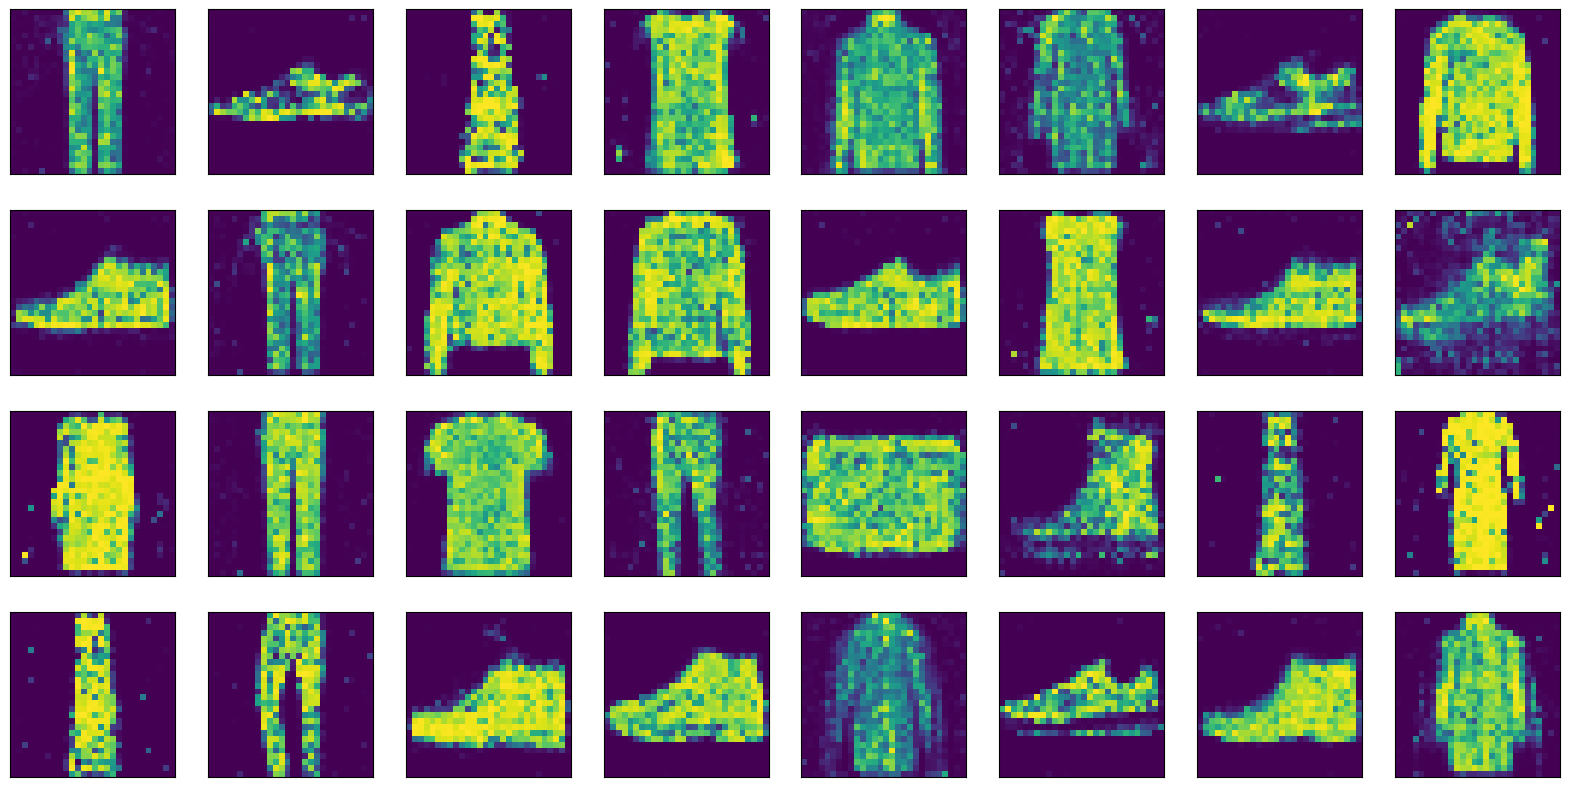

at epoch 50, dloss: 1.2209781408309937, gloss 0.9226890802383423


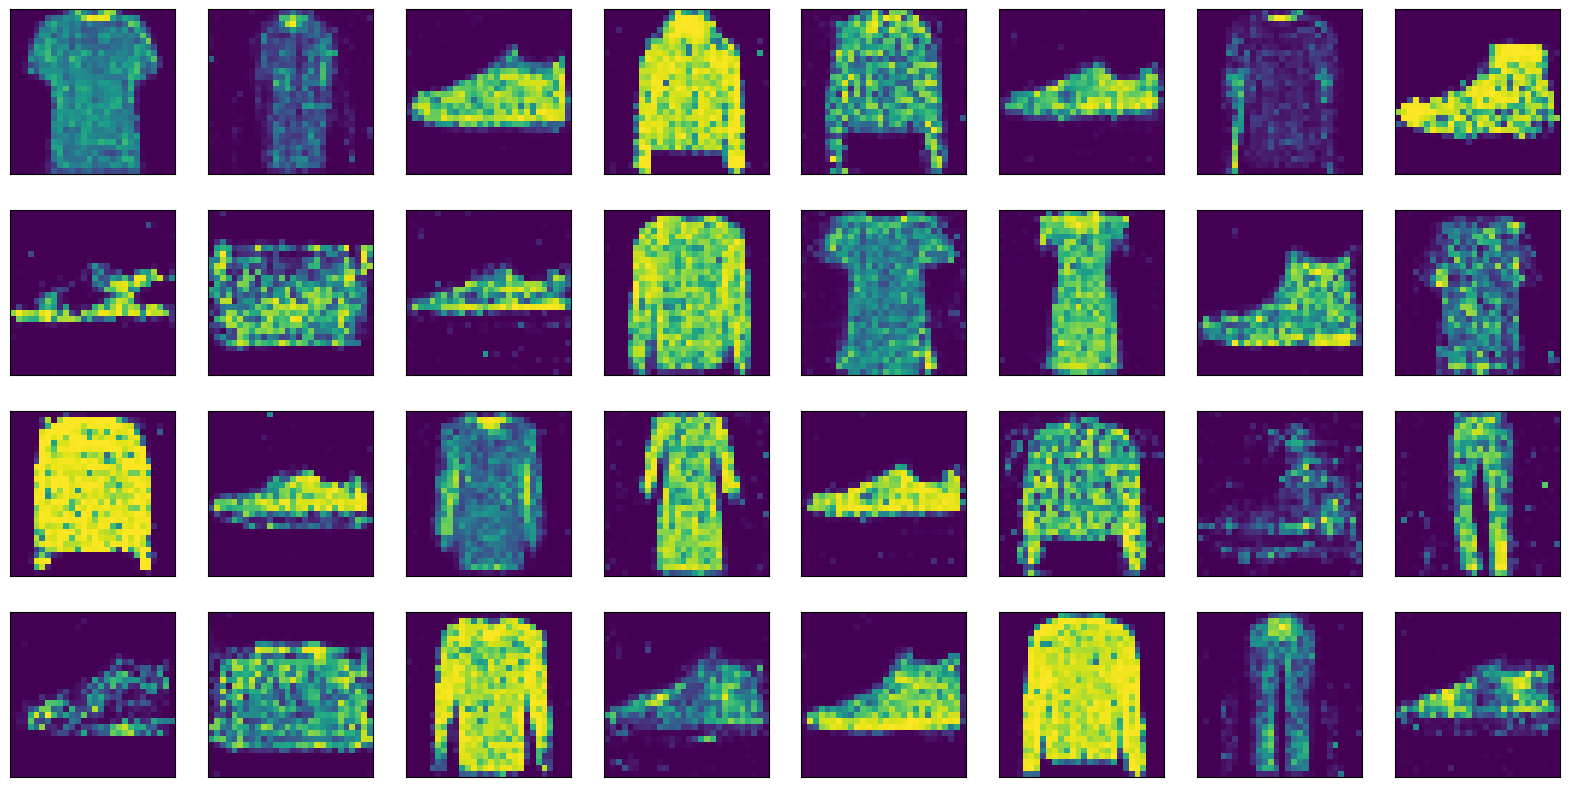

In [13]:
for i in range(50):
    gloss=0
    dloss=0
    for n, (real_samples,_) in enumerate(train_loader):
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G=train_G()
        gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n    
    if i % 10 == 9:
        print(f"at epoch {i+1}, dloss: {dloss}, gloss {gloss}")
        see_output()

In [14]:
# Export to TorchScript
scripted = torch.jit.script(G) 
# Save the model
import os
os.makedirs("files", exist_ok=True)
scripted.save('files/fashion_gen.pt') 

In [15]:
new_G=torch.jit.load('files/fashion_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=Tanh)
)

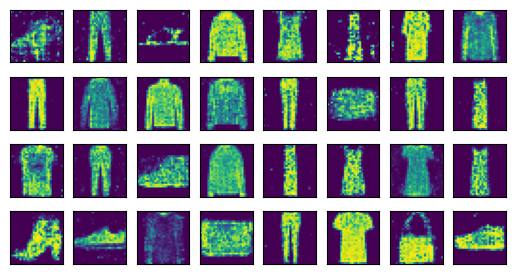

In [16]:
noise=torch.randn(batch_size,100).to(device=device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((fake_samples[i]/2+0.5).reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 